In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigh

In [2]:
# Load images
def loadMnistImages(filepath):
    with open(filepath, 'rb') as f:
        magic, num, rows, cols = np.frombuffer(f.read(16), dtype='>u4')
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return data.reshape(num, rows, cols)

# Load labels
def loadMnistLabels(filepath):
    with open(filepath, 'rb') as f:
        magic, num = np.frombuffer(f.read(8), dtype='>u4')
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return data

In [3]:
def applyPCA(X, k=5):
    mu = np.mean(X, axis=1, keepdims=True)
    Xc = X - mu
    S = (Xc @ Xc.T) / (X.shape[1] - 1)
    eigValues, eigVectors = np.linalg.eigh(S)
    sortedIndices = np.argsort(eigValues)[::-1]
    sortedEigVectors = eigVectors[:, sortedIndices]
    Up = sortedEigVectors[:, :k]
    Z = Up.T @ Xc
    return Z, Up, mu

In [4]:
def find_best_stump(X, Y, weights):
    N = X.shape[1]
    num_features = X.shape[0]
    best_error = float('inf')
    best_feature = None
    best_threshold = None
    best_polarity = None
    best_predictions = None

    for feature in range(num_features):
        feature_values = X[feature, :]
        min_val = np.min(feature_values)
        max_val = np.max(feature_values)
        range_val = max_val - min_val
        cuts = [min_val + 0.25 * range_val, min_val + 0.50 * range_val, min_val + 0.75 * range_val]

        for threshold in cuts:
            for polarity in [+1, -1]:
                preds = np.ones(N)
                if polarity == 1:
                    preds[feature_values <= threshold] = -1
                else:
                    preds[feature_values > threshold] = -1

                error = np.sum(weights[preds != Y])

                if error < best_error:
                    best_error = error
                    best_feature = feature
                    best_threshold = threshold
                    best_polarity = polarity
                    best_predictions = preds.copy()

    return best_feature, best_threshold, best_polarity, best_error, best_predictions

In [5]:
def exp_loss(Y_true, pred):
        F = pred  
        return np.mean(np.exp(-Y_true * F))

In [6]:
def log_loss(y_true, f_pred):
    return np.mean(np.log(1 + np.exp(-y_true * f_pred)))

In [7]:
def predict_output(X, stumps, betas):
        final_pred = np.zeros(X.shape[1])
        for stump_info, beta in zip(stumps, betas):
            f, thresh, pol = stump_info
            x_f = X[f, :]
            pred = np.ones(X.shape[1])
            if pol == 1:
                pred[x_f <= thresh] = -1
            else:
                pred[x_f > thresh] = -1
            final_pred += beta * pred
        return final_pred

In [ ]:
# Load Dataset
trainImagesPath = "Dataset/train-images.idx3-ubyte"
trainLabelsPath = "Dataset/train-labels.idx1-ubyte"
trainImages = loadMnistImages(trainImagesPath)
trainLabels = loadMnistLabels(trainLabelsPath)

testImagesPath = "Dataset/t10k-images.idx3-ubyte"
testLabelsPath = "Dataset/t10k-labels.idx1-ubyte"
testImages = loadMnistImages(testImagesPath)
testLabels = loadMnistLabels(testLabelsPath)

In [9]:
np.random.seed(2023217)

# Selecting training set (1000 random images from each class)
selectedImages = []
selectedLabels = []
for digit in [0, 1]:
    indices = np.where(trainLabels == digit)[0]
    selectedIndices = np.random.choice(indices, size=1000, replace=False)
    selectedImages.append(trainImages[selectedIndices])
    selectedLabels.append(trainLabels[selectedIndices])
X_train = np.vstack(selectedImages).astype(np.float32) / 255.0
Y_train = np.hstack(selectedLabels)
X_train = X_train.reshape(X_train.shape[0], -1).T

# Selecting all test images
selectedTestImages = []
selectedTestLabels = []
for digit in [0, 1]:
    indices = np.where(testLabels == digit)[0]
    selectedTestImages.append(testImages[indices].astype(np.float32) / 255.0)
    selectedTestLabels.append(testLabels[indices])
X_test = np.vstack(selectedTestImages)
Y_test = np.hstack(selectedTestLabels)
X_test = X_test.reshape(X_test.shape[0], -1).T

In [10]:
print("Shape of X_train:", X_train.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_test:", Y_test.shape)

Shape of X_train: (784, 2000)
Shape of Y_train: (2000,)
Shape of X_test: (784, 2115)
Shape of Y_test: (2115,)


In [11]:
numTrainSamples = X_train.shape[1]
indices = np.random.permutation(numTrainSamples)
splitIndex = int(0.75 * numTrainSamples)

trainIndices = indices[:splitIndex]
valIndices = indices[splitIndex:]

X_train_raw = X_train[:, trainIndices]
Y_train_final = Y_train[trainIndices]

X_val_raw = X_train[:, valIndices]
Y_val = Y_train[valIndices]

X_train_pca, Up, mu = applyPCA(X_train_raw, k=5)

# Applying PCA to validation set
X_val_centered = X_val_raw - mu
X_val = Up.T @ X_val_centered

# Applying PCA to test set
X_test_centered = X_test - mu
X_test_pca = Up.T @ X_test_centered

X_train_final = X_train_pca

In [12]:
print("X_train_final shape:", X_train_final.shape)
print("Y_train_final shape:", Y_train_final.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)
print("X_test_pca shape:", X_test_pca.shape)
print("Y_test shape:", Y_test.shape)

X_train_final shape: (5, 1500)
Y_train_final shape: (1500,)
X_val shape: (5, 500)
Y_val shape: (500,)
X_test_pca shape: (5, 2115)
Y_test shape: (2115,)


In [13]:
# Convert labels to {-1, +1}
Y_train_bin = np.where(Y_train_final == 0, -1, 1)
Y_val_bin = np.where(Y_val == 0, -1, 1)
Y_test_bin = np.where(Y_test == 0, -1, 1)

N_train = X_train_final.shape[1]

weights = np.ones(N_train) / N_train

stumps = []
betas = []

train_losses = []
val_losses = []
test_losses = []
train_errors = []

early_stop_round = 200  
best_val_loss = float('inf')
patience = 10
wait = 0

for t in range(200):
    stump = find_best_stump(X_train_final, Y_train_bin, weights)
    feature, threshold, polarity, error, preds = stump

    error = max(error, 1e-10)
    beta = 0.5 * np.log((1 - error) / error)

    weights *= np.exp(-beta * Y_train_bin * preds)
    weights /= np.sum(weights)

    stumps.append((feature, threshold, polarity))
    betas.append(beta)

    train_pred = predict_output(X_train_final, stumps, betas)
    val_pred = predict_output(X_val, stumps, betas)
    test_pred = predict_output(X_test_pca, stumps, betas)

    train_loss = exp_loss(Y_train_bin, train_pred)
    val_loss = exp_loss(Y_val_bin, val_pred)
    test_loss = exp_loss(Y_test_bin, test_pred)

    train_error = np.mean(np.sign(train_pred) != Y_train_bin)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    train_errors.append(train_error)

    min_improvement = 1e-6

    if val_loss < best_val_loss - min_improvement:
        best_val_loss = val_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience and early_stop_round == 200:
            early_stop_round = t + 1 

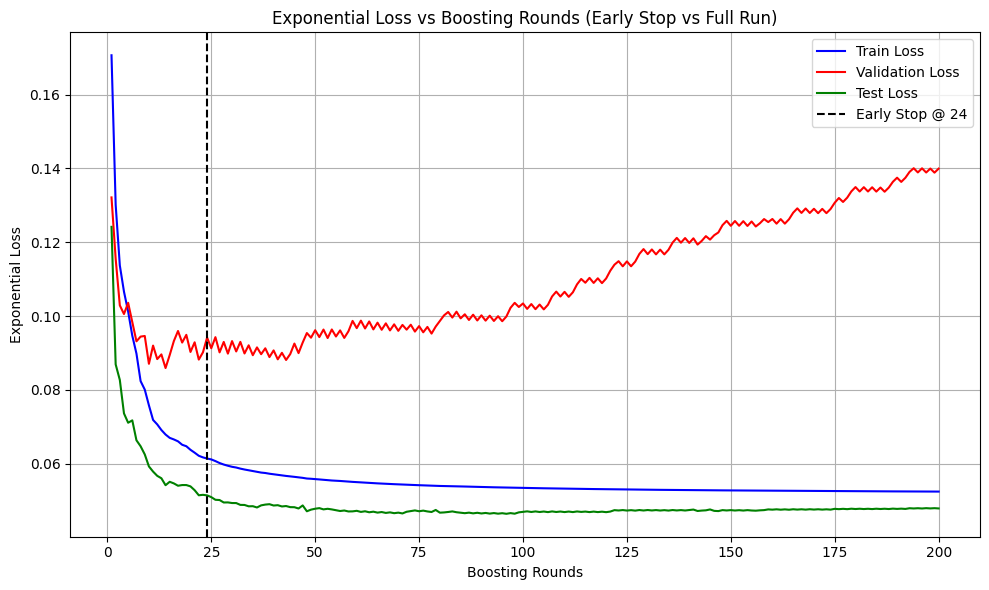

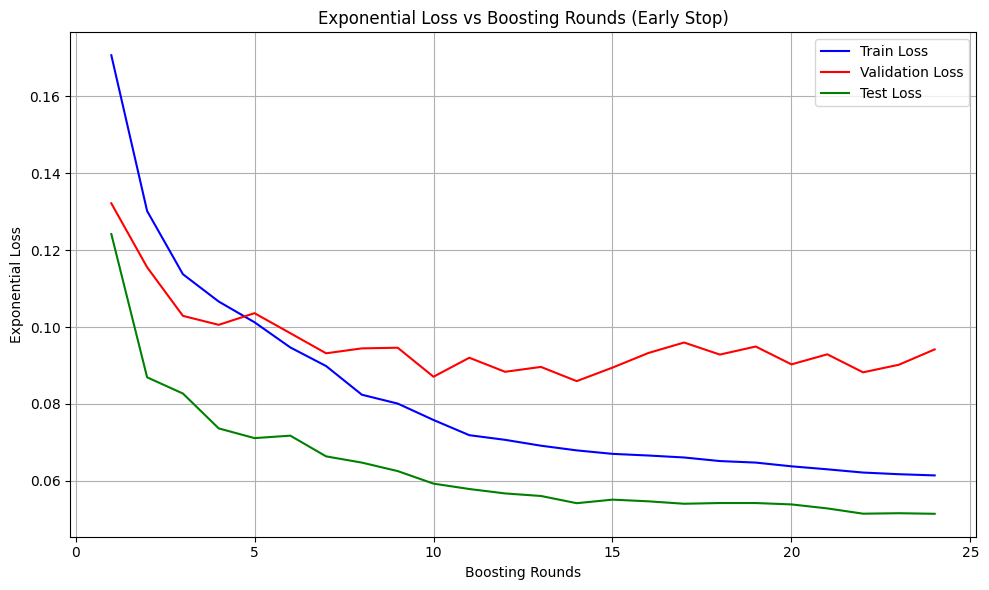

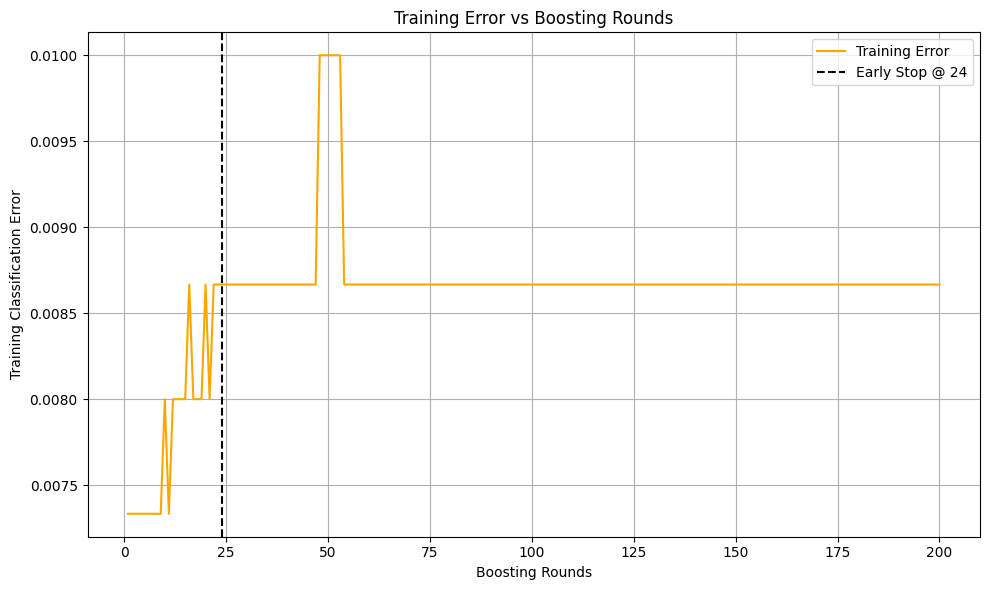

In [14]:
rounds = np.arange(1, 201)

# Loss Plot
plt.figure(figsize=(10, 6))
plt.plot(rounds, train_losses, label='Train Loss', color='blue')
plt.plot(rounds, val_losses, label='Validation Loss', color='red')
plt.plot(rounds, test_losses, label='Test Loss', color='green')
plt.axvline(early_stop_round, color='black', linestyle='--', label=f'Early Stop @ {early_stop_round}')
plt.xlabel("Boosting Rounds")
plt.ylabel("Exponential Loss")
plt.title("Exponential Loss vs Boosting Rounds (Early Stop vs Full Run)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

stop_round = np.arange(1, early_stop_round + 1)
plt.figure(figsize=(10, 6))
plt.plot(stop_round, train_losses[:early_stop_round], label='Train Loss', color='blue')
plt.plot(stop_round, val_losses[:early_stop_round], label='Validation Loss', color='red')
plt.plot(stop_round, test_losses[:early_stop_round], label='Test Loss', color='green')
#plt.axvline(early_stop_round, color='black', linestyle='--', label=f'Early Stop @ {early_stop_round}')
plt.xlabel("Boosting Rounds")
plt.ylabel("Exponential Loss")
plt.title("Exponential Loss vs Boosting Rounds (Early Stop)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Training Error Plot
plt.figure(figsize=(10, 6))
plt.plot(rounds, train_errors, label='Training Error', color='orange')
plt.axvline(early_stop_round, color='black', linestyle='--', label=f'Early Stop @ {early_stop_round}')
plt.xlabel("Boosting Rounds")
plt.ylabel("Training Classification Error")
plt.title("Training Error vs Boosting Rounds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
final_test_preds_full = np.sign(predict_output(X_test_pca, stumps, betas))
test_accuracy_full = np.mean(final_test_preds_full == Y_test_bin)

final_test_preds_early = np.sign(predict_output(X_test_pca, stumps[:early_stop_round], betas[:early_stop_round]))
test_accuracy_early = np.mean(final_test_preds_early == Y_test_bin)

# Print both
print(f"Test Accuracy at Early Stopping Round ({early_stop_round}): {test_accuracy_early * 100:.2f}%")
print(f"Test Accuracy after 200 Rounds: {test_accuracy_full * 100:.2f}%")

Test Accuracy at Early Stopping Round (24): 99.39%
Test Accuracy after 200 Rounds: 99.01%
